# Covariates - Imports

In [21]:
import matplotlib.pyplot as plt 
import statsmodels.formula.api as smf 
from patsy import dmatrix 
import pandas as pd

from utils import get_filtered_data, create_future_dataframe, plot_series

In [22]:
#Reading the data
df = get_filtered_data()

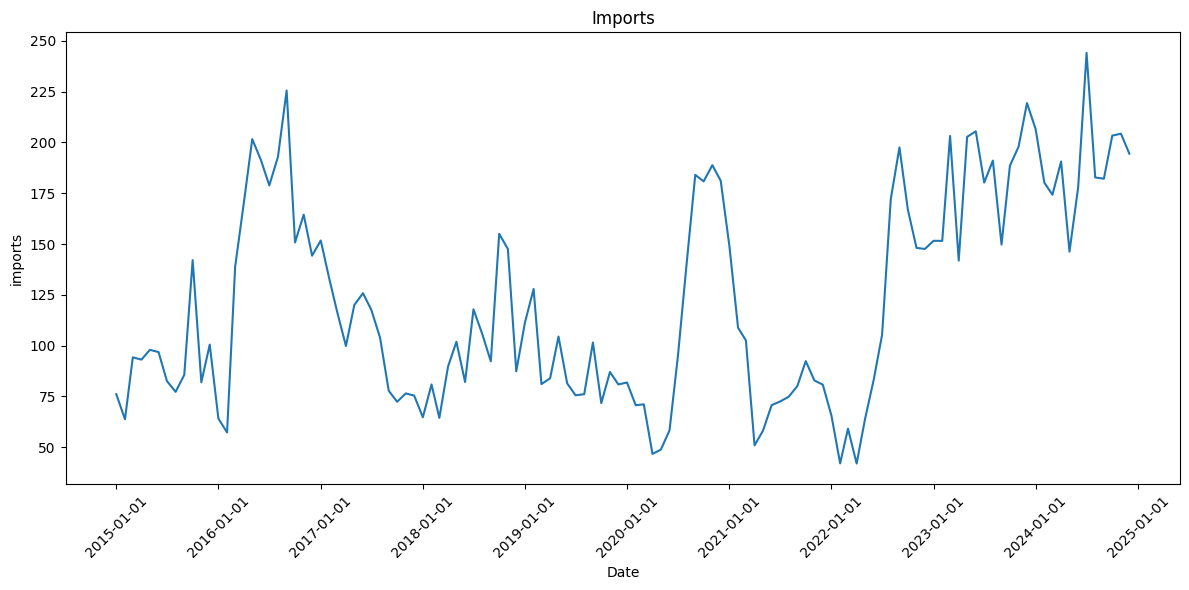

In [23]:
imports = df[['date', 'imports']] 
plot_series(imports, 'imports')

### Careful !


Right away, we can see that the imports series seems to be very unpredictable.
From 2023 and beyond seems to be a certain seasonality but, we can't be sure by just looking at the plot. 

That kind of series is really difficult to model. Right away it's quite clear that linear models won't capture the signal. And the signal itself it's hard to identify. 

With that in mind, we have to keep in mind that this curve fitting and the posterior predictions can't be trusted as a good forecast for future values of imports.

To better model its behavior we can use some non-linear functions or even machine-learning methods.

### Naive OLS Solution

In [24]:
imports = (
    imports
    .assign(
        t = range(len(imports)),
        month = imports["date"].dt.month
    )
)

# Fit linear regression with trend + seasonal dummies
model_imports_ols = smf.ols("imports ~ t + C(month)", data=imports).fit()

In [8]:
model_imports_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                imports   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     2.296
Date:                Tue, 30 Sep 2025   Prob (F-statistic):             0.0121
Time:                        22:00:55   Log-Likelihood:                -628.33
No. Observations:                 120   AIC:                             1283.
Df Residuals:                     107   BIC:                             1319.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         83.2860     16.714      4.983      0.000      50.153     116.419
C(month)[T.2]    -11.2222     21.537     -0.521      0.603     -53.917      31.473
C(month)[T.3]     -2.7843     21.538     -0.129      0.897     -45.481      39.913
C(month)[T.4]    -12.9746     21.540     -0.602      0.548     -55.675      29.726
C(month)[T.5]      0.1763     21.543      0.008      0.993     -42.530      42.882
C(month)[T.6]      2.3727     21.546      0.110      0.913     -40.340      45.085
C(month)[T.7]     11.4641     21.550      0.532      0.596     -31.257      54.185
C(month)[T.8]     15.6827     21.555      0.728      0.468     -27.048      58.413
C(month)[T.9]     21.0809     21.561      0.978      0.330     -21.661      63.823
C(month)[T.10]    25.3086     21.567      1.173      0.243     -17.446      68.063
C(month)[T.11]    20.3191     21.574      0.942      0.348     -22.450      63.088
C(month)[T.12]    13.0075     21.582      0.603      0.548     -29.777      55.792
t                  0.5368      0.128      4.208      0.000       0.284       0.790
==============================================================================
Omnibus:                        6.166   Durbin-Watson:                   0.349
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                3.723
Skew:                           0.245   Prob(JB):                        0.155
Kurtosis:                       2.289   Cond. No.                         857.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Splines - Non-Linear Model

In [27]:
# Natural spline basis for trend
spline_basis = dmatrix("bs(t, df=20, degree=3, include_intercept=False)", 
                       {"t": imports["t"]}, return_type='dataframe')
# Give them simple names
spline_basis.columns = [f"spline_{i}" for i in range(spline_basis.shape[1])]

# Merge back
imports = pd.concat([imports, spline_basis], axis=1)

In [28]:
# Build formula with the expanded spline columns
formula = "imports ~ " + " + ".join(spline_basis.columns) + " + C(month)"
model_imports_splines = smf.ols(formula=formula, data=imports).fit()

In [29]:
model_imports_splines.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                imports   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     12.77
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           3.21e-21
Time:                        22:12:59   Log-Likelihood:                -539.82
No. Observations:                 120   AIC:                             1144.
Df Residuals:                      88   BIC:                             1233.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         31.4200     11.511      2.730      0.008       8.544      54.296
C(month)[T.2]    -17.3537     11.609     -1.495      0.139     -40.424       5.717
C(month)[T.3]    -12.1560     11.968     -1.016      0.313     -35.940      11.629
C(month)[T.4]    -22.9921     12.132     -1.895      0.061     -47.101       1.117
C(month)[T.5]     -8.3589     12.093     -0.691      0.491     -32.390      15.673
C(month)[T.6]     -3.1864     12.007     -0.265      0.791     -27.048      20.676
C(month)[T.7]      9.4342     12.039      0.784      0.435     -14.492      33.360
C(month)[T.8]     16.5958     12.191      1.361      0.177      -7.631      40.822
C(month)[T.9]     23.5221     12.300      1.912      0.059      -0.922      47.966
C(month)[T.10]    27.5723     12.218      2.257      0.027       3.291      51.854
C(month)[T.11]    20.5643     11.968      1.718      0.089      -3.220      44.348
C(month)[T.12]     9.4414     11.869      0.795      0.428     -14.146      33.029
spline_0          31.4200     11.511      2.730      0.008       8.544      54.296
spline_1         108.4138     49.610      2.185      0.032       9.824     207.004
spline_2         -67.6704     37.769     -1.792      0.077    -142.728       7.387
spline_3          89.8867     38.191      2.354      0.021      13.990     165.783
spline_4         126.1418     33.326      3.785      0.000      59.914     192.370
spline_5          72.3454     34.572      2.093      0.039       3.641     141.050
spline_6         -18.3485     32.800     -0.559      0.577     -83.531      46.834
spline_7          36.9062     34.053      1.084      0.281     -30.767     104.579
spline_8          50.6948     32.282      1.570      0.120     -13.460     114.849
spline_9          36.4335     33.960      1.073      0.286     -31.054     103.921
spline_10        -26.2193     32.078     -0.817      0.416     -89.968      37.529
spline_11         51.2666     33.890      1.513      0.134     -16.083     118.616
spline_12        110.9666     32.442      3.420      0.001      46.495     175.438
spline_13        -47.4345     33.785     -1.404      0.164    -114.576      19.707
spline_14         13.1299     33.260      0.395      0.694     -52.968      79.227
spline_15         67.6756     33.820      2.001      0.048       0.466     134.885
spline_16        144.6716     34.654      4.175      0.000      75.805     213.538
spline_17         88.0256     35.917      2.451      0.016      16.648     159.404
spline_18        171.6267     42.324      4.055      0.000      87.516     255.738
spline_19         82.0772     42.359      1.938      0.056      -2.103     166.257
spline_20        126.9488     33.702      3.767      0.000      59.974     193.924
==============================================================================
Omnibus:        

## Visualizing the Model Fit on Training Data

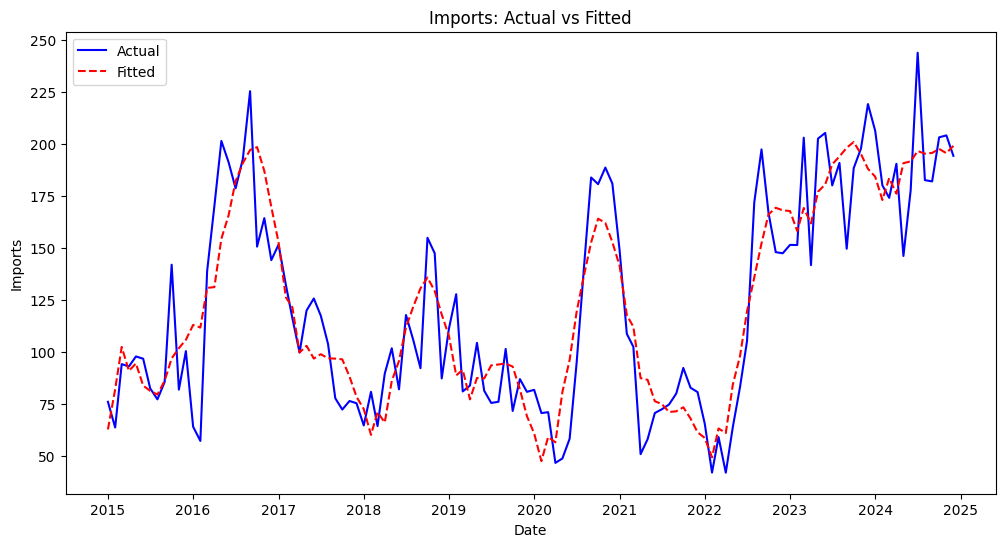

In [31]:
imports['fitted'] = model_imports_splines.fittedvalues

# Plot actual vs fitted
plt.figure(figsize=(12, 6))
plt.plot(imports["date"], imports["imports"], label="Actual", color="blue")
plt.plot(imports["date"], imports["fitted"], label="Fitted", color="red", linestyle="--")

plt.title("Imports: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Imports")
plt.legend()
plt.show()

We can see we have a much better fit than just using a simple OLS with a linear trend. 

Once we have a clear non-linear trend, using polynomial splines to better fit the data is a nice approach.

We can see it by looking at the $R^2_{adjusted} = 0.75$

## Visualizing the Predictions on the Test set

In [34]:
test_df = create_future_dataframe() 

# Recompute spline basis with the SAME settings
spline_test = dmatrix("bs(t, df=20, degree=3, include_intercept=False)",
                      {"t": test_df["t"]}, return_type="dataframe")

# Use the same column names as training
spline_test.columns = [f"spline_{i}" for i in range(spline_test.shape[1])]

# Merge with test
test_df = pd.concat([test_df, spline_test], axis=1)

test_df['imports'] = model_imports_splines.predict(test_df)

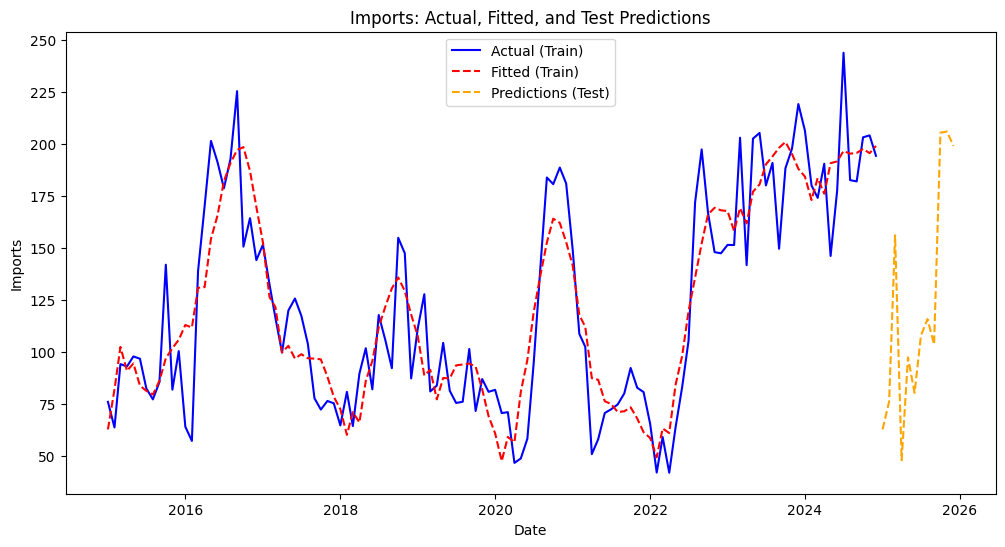

In [36]:
# Plot
plt.figure(figsize=(12, 6))

# Actual (train only)
plt.plot(imports["date"], imports["imports"],
         label="Actual (Train)", color="blue") 

# Fitted (train only)
plt.plot(imports["date"], imports["fitted"],
         label="Fitted (Train)", color="red", linestyle="--")

# Predictions (test only)
plt.plot(test_df["date"], test_df["imports"],
         label="Predictions (Test)", color="orange", linestyle="--")

plt.title("Imports: Actual, Fitted, and Test Predictions")
plt.xlabel("Date")
plt.ylabel("Imports")
plt.legend()
plt.show()

# Caveat!

Even though our spline OLS model showed a nice $R^2$ in training, here we're trying to predict the behavior of a variable that shows no clear trend or seasonality. 

So, our forecast can be one among many. That's why it's really important to have in mind that those predictions can't be trusted blindly as a proxy for future values of `Imports`. 

We're just sort of understanding the behavior of `imports` so to build future values of this exogenous variable for our future predictions of `farmgate_milk_price`. 


## Saving the Test Results

In [37]:
test_df[['date', 'imports']]

,date,imports
0,2025-01-01,62.840082
1,2025-02-01,76.249004
2,2025-03-01,156.256014
3,2025-04-01,48.015291
4,2025-05-01,97.500741
5,2025-06-01,80.418765
6,2025-07-01,107.969371
7,2025-08-01,115.930238
8,2025-09-01,103.699925
9,2025-10-01,205.592904


In [38]:
test_df[['date', 'imports']].to_csv("../../predictions/2025_imports.csv", index=False)